
# PROJET DL : TRANSFER LEARNING




In [8]:
# ============================================================================
# PART 1 : IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16, MobileNetV2, Xception
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import warnings
warnings.filterwarnings('ignore')

In [9]:
# ============================================================================
# PART 2 : DOWNLOADING AND LOADING KAGGLE DATASET
# ============================================================================

print("=" * 80)
print("STEP 1 : DOWNLOADING AND LOADING KAGGLE DATASET")
print("=" * 80)

# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print(f"Dataset downloaded: {dataset_path}")

# Build the path to the image folder
dataset_dir = os.path.join(dataset_path, 'flower_images')

print(f"Images folder: {dataset_dir}")

# Load the data
data = load_files(dataset_dir, load_content=False)
class_names = data.target_names
num_classes = len(class_names)
image_paths = np.array(data.filenames)
labels = np.array(data.target)

print("Dataset loaded")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Total number of images: {len(image_paths)}")

STEP 1 : DOWNLOADING AND LOADING KAGGLE DATASET
Dataset downloaded: C:\Users\user\.cache\kagglehub\datasets\kausthubkannan\5-flower-types-classification-dataset\versions\1
Images folder: C:\Users\user\.cache\kagglehub\datasets\kausthubkannan\5-flower-types-classification-dataset\versions\1\flower_images
Dataset loaded
Number of classes: 5
Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
Total number of images: 5000


 Class  Number of images
     0              1000
     3              1000
     4              1000
     2              1000
     1              1000


<Figure size 1000x500 with 0 Axes>

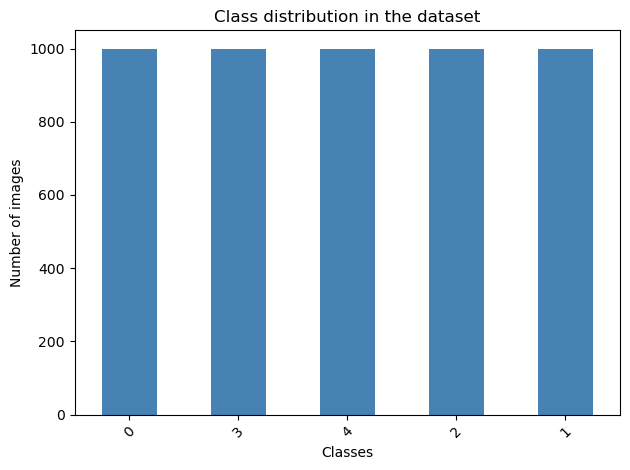

In [10]:
# Convert labels to a pandas Series
serie = pd.Series(labels, name="class")

# Count occurrences of each class
counts = serie.value_counts()

# Create a DataFrame for class distribution
class_distribution = counts.reset_index()
class_distribution.columns = ["Class", "Number of images"]

print(class_distribution.to_string(index=False))

# Plot class distribution
plt.figure(figsize=(10, 5))
class_distribution.plot.bar(x="Class", y="Number of images", color='steelblue', legend=False)
plt.title('Class distribution in the dataset')
plt.xlabel('Classes')
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

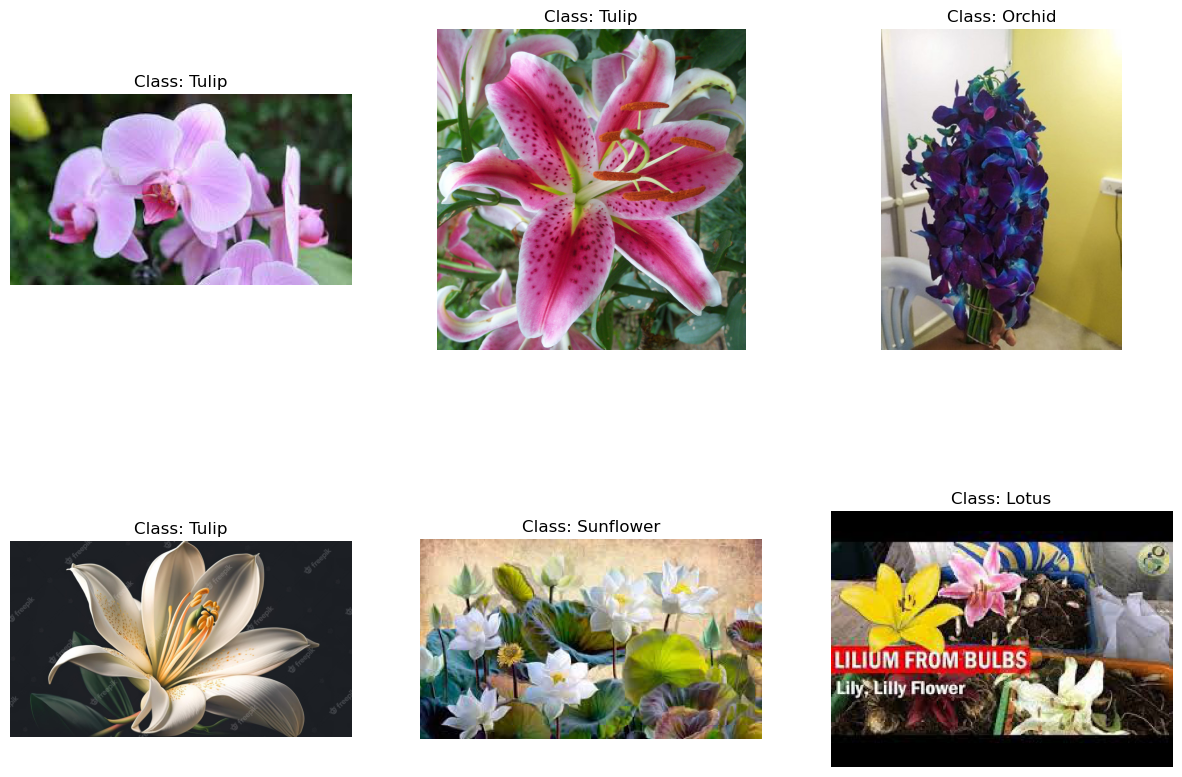

In [11]:
# ============================================================================
# PART 4 : VISUALIZATION OF SAMPLE IMAGES
# ============================================================================

# Convert existing lists into a TensorFlow Dataset
paths = tf.constant(image_paths)
labels_tf = tf.constant(labels)

dataset = tf.data.Dataset.from_tensor_slices((paths, labels_tf))

# Select 6 random images
sample = dataset.shuffle(10000).take(6)

# Extract paths and labels (no explicit for-loop)
chosen_paths = list(sample.map(lambda x, y: x).as_numpy_iterator())
chosen_labels = list(sample.map(lambda x, y: y).as_numpy_iterator())

# Load the images (still without explicit loops)
loaded_imgs = list(map(lambda p: tf.keras.utils.load_img(p), chosen_paths))

# Display the images
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

# Implicit loop using map() + enumerate
list(map(
    lambda info: (
        plt.subplot(2, 3, info[0] + 1),
        plt.imshow(info[1]),
        plt.title(f"Class: {class_names[chosen_labels[info[0]]]}"),
        plt.axis("off")
    ),
    enumerate(loaded_imgs)
))

plt.show()

In [12]:
# ============================================================================
# PART 5 : TRAIN / VALIDATION / TEST SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4 : TRAIN / VALIDATION / TEST SPLIT")
print("=" * 80)

# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"Validation: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"Test: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")


STEP 4 : TRAIN / VALIDATION / TEST SPLIT
Train: 3000 images (60.0%)
Validation: 1000 images (20.0%)
Test: 1000 images (20.0%)


In [13]:
# ============================================================================
# PART 6 : DATA AUGMENTATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5 : DATA AUGMENTATION")
print("=" * 80)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

print("Data augmentation configured successfully")
print("  - Rotation: 40°")
print("  - Width/Height shift: 20%")
print("  - Zoom range: 20%")
print("  - Horizontal flip: Yes")
print("  - Brightness: 80–120%")


STEP 5 : DATA AUGMENTATION
Found 5000 images belonging to 5 classes.
Data augmentation configured successfully
  - Rotation: 40°
  - Width/Height shift: 20%
  - Zoom range: 20%
  - Horizontal flip: Yes
  - Brightness: 80–120%


In [14]:
# ============================================================================
# PART 7 : HYPERPARAMETERS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6 : DEFINING HYPERPARAMETERS")
print("=" * 80)

input_size = (299, 299)
batch_size = 32
epochs = 30
learning_rate_1 = 0.001
learning_rate_2 = 0.0005

print(f"Image size: {input_size}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning rates: {learning_rate_1}, {learning_rate_2}")


STEP 6 : DEFINING HYPERPARAMETERS
Image size: (299, 299)
Batch size: 32
Epochs: 30
Learning rates: 0.001, 0.0005


In [15]:
# ============================================================================
# MODEL 1 : InceptionV3 with Learning Rate 0.001
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 1 : InceptionV3 (LR = 0.001)")
print("=" * 80)

base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_inception.trainable = False

inputs_1 = Input(shape=(299, 299, 3))
x = base_inception(inputs_1, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs_1 = Dense(num_classes, activation='softmax')(x)

model_1 = Model(inputs_1, outputs_1, name='InceptionV3_001')

model_1.compile(
    optimizer=Adam(learning_rate=learning_rate_1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nInceptionV3 Architecture:")
model_1.summary()

total_params_1 = model_1.count_params()
trainable_params_1 = sum([tf.keras.backend.count_params(w) for w in model_1.trainable_weights])
non_trainable_params_1 = total_params_1 - trainable_params_1

print(f"\n Total parameters: {total_params_1:,}")
print(f" Trainable parameters: {trainable_params_1:,}")
print(f" Frozen parameters: {non_trainable_params_1:,}")

# Training Model 1
early_stop_1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_1 = model_1.fit(
    train_generator,
    epochs=epochs,
    validation_data=train_generator,
    callbacks=[early_stop_1, reduce_lr_1],
    verbose=1
)

test_loss_1, test_acc_1 = model_1.evaluate(train_generator, verbose=0)
print(f"\n Test Loss: {test_loss_1:.4f}")
print(f" Test Accuracy: {test_acc_1:.4f}")

model_1.save('/content/inceptionv3_001.h5')


MODEL 1 : InceptionV3 (LR = 0.001)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

InceptionV3 Architecture:


Model: "InceptionV3_001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,360,869 (85.30 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


 Total parameters: 22,360,869
 Trainable parameters: 558,085
 Frozen parameters: 21,802,784
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.5236 - loss: 1.1720 - val_accuracy: 0.7996 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.7076 - loss: 0.7918 - val_accuracy: 0.7630 - val_loss: 0.6707 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.7482 - loss: 0.6846 - val_accuracy: 0.8150 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7616 - loss: 0.6699 - val_accuracy: 0.8490 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.7736 - loss: 0.6127 - val_accuracy: 0.8458 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7928 - loss: 0.5894 - val_accuracy: 0.8576 - val_loss: 0.4021 - learning_ra


 Test Loss: 0.2507
 Test Accuracy: 0.9112


In [16]:
# ============================================================================
# MODEL 2 : ResNet50 with fine-tuning and correct preprocessing
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 2 : ResNet50 (Fine-tuning, LR = 0.0005)")
print("=" * 80)

# Base model
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable = False  # Freeze initially

# Add custom top layers
inputs_2 = Input(shape=(224, 224, 3))
x = preprocess_input(inputs_2)               # Proper ResNet preprocessing
x = base_resnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs_2 = Dense(num_classes, activation='softmax')(x)

model_2 = Model(inputs_2, outputs_2, name='ResNet50_finetune')

model_2.compile(
    optimizer=Adam(learning_rate=learning_rate_2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResNet50 Architecture:")
model_2.summary()

# ================================
# Generators with validation split
# ================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # Reserve 20% for validation
)

train_generator_224 = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

val_generator_224 = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# =================================
# Fine-tuning: unfreeze last block
# =================================
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

# Recompile with lower LR for fine-tuning
model_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ============================
# Callbacks
# ============================
early_stop_2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# ============================
# Training
# ============================
history_2 = model_2.fit(
    train_generator_224,
    epochs=epochs,
    validation_data=val_generator_224,
    callbacks=[early_stop_2, reduce_lr_2],
    verbose=1
)

# ============================
# Evaluation
# ============================
test_loss_2, test_acc_2 = model_2.evaluate(val_generator_224, verbose=0)
print(f"\n Test Loss: {test_loss_2:.4f}")
print(f" Test Accuracy: {test_acc_2:.4f}")

# Save model
model_2.save('/content/resnet50_finetune.h5')


MODEL 2 : ResNet50 (Fine-tuning, LR = 0.0005)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

ResNet50 Architecture:


Model: "ResNet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │        645 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.2880 - loss: 1.5657 - val_accuracy: 0.3610 - val_loss: 1.4798 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.4038 - loss: 1.3880 - val_accuracy: 0.4690 - val_loss: 1.2282 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.4638 - loss: 1.2818 - val_accuracy: 0.4050 - val_loss: 1.6100 - learning_rate: 1.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4773 - loss: 1.2639 - val_accuracy: 0.4430 - val_loss: 1.2692 - learning_rate: 1.0000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4983 - loss: 1.2298 - val_accuracy: 0.4120 - val_loss: 1.4974 - learning_rate: 1.0000e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5270 - loss: 1.1813 - val_accuracy: 0.5400 - val_loss: 1.1300 - 


 Test Loss: 0.8500
 Test Accuracy: 0.6700


In [17]:
# ============================================================================
# MODEL 3 : VGG16 with Learning Rate 0.001
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3 : VGG16 (LR = 0.001)")
print("=" * 80)

base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_vgg.trainable = False

inputs_3 = Input(shape=(224, 224, 3))
x = base_vgg(inputs_3, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs_3 = Dense(num_classes, activation='softmax')(x)

model_3 = Model(inputs_3, outputs_3, name='VGG16_001')

model_3.compile(
    optimizer=Adam(learning_rate=learning_rate_1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nVGG16 Architecture:")
model_3.summary()

total_params_3 = model_3.count_params()
trainable_params_3 = sum([tf.keras.backend.count_params(w) for w in model_3.trainable_weights])
non_trainable_params_3 = total_params_3 - trainable_params_3

print(f"\n Total parameters: {total_params_3:,}")
print(f" Trainable parameters: {trainable_params_3:,}")
print(f" Frozen parameters: {non_trainable_params_3:,}")

# Training Model 3
early_stop_3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_3 = model_3.fit(
    train_generator_224,
    epochs=epochs,
    validation_data=train_generator_224,
    callbacks=[early_stop_3, reduce_lr_3],
    verbose=1
)

test_loss_3, test_acc_3 = model_3.evaluate(train_generator_224, verbose=0)
print(f"\n Test Loss: {test_loss_3:.4f}")
print(f" Test Accuracy: {test_acc_3:.4f}")

model_3.save('/content/vgg16_001.h5')


MODEL 3 : VGG16 (LR = 0.001)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

VGG16 Architecture:


Model: "VGG16_001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


 Total parameters: 14,879,557
 Trainable parameters: 164,869
 Frozen parameters: 14,714,688
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.3602 - loss: 1.4885 - val_accuracy: 0.6150 - val_loss: 1.1616 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.5717 - loss: 1.1096 - val_accuracy: 0.6910 - val_loss: 0.8686 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.6435 - loss: 0.9532 - val_accuracy: 0.7180 - val_loss: 0.7857 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.6865 - loss: 0.8410 - val_accuracy: 0.7287 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.7035 - loss: 0.7885 - val_accuracy: 0.7667 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7170 - loss: 0.7493 - val_accuracy: 0.7757 - val_loss: 0.6104 - learning_ra


 Test Loss: 0.3847
 Test Accuracy: 0.8633



STEP 8 : LEARNING CURVES VISUALIZATION


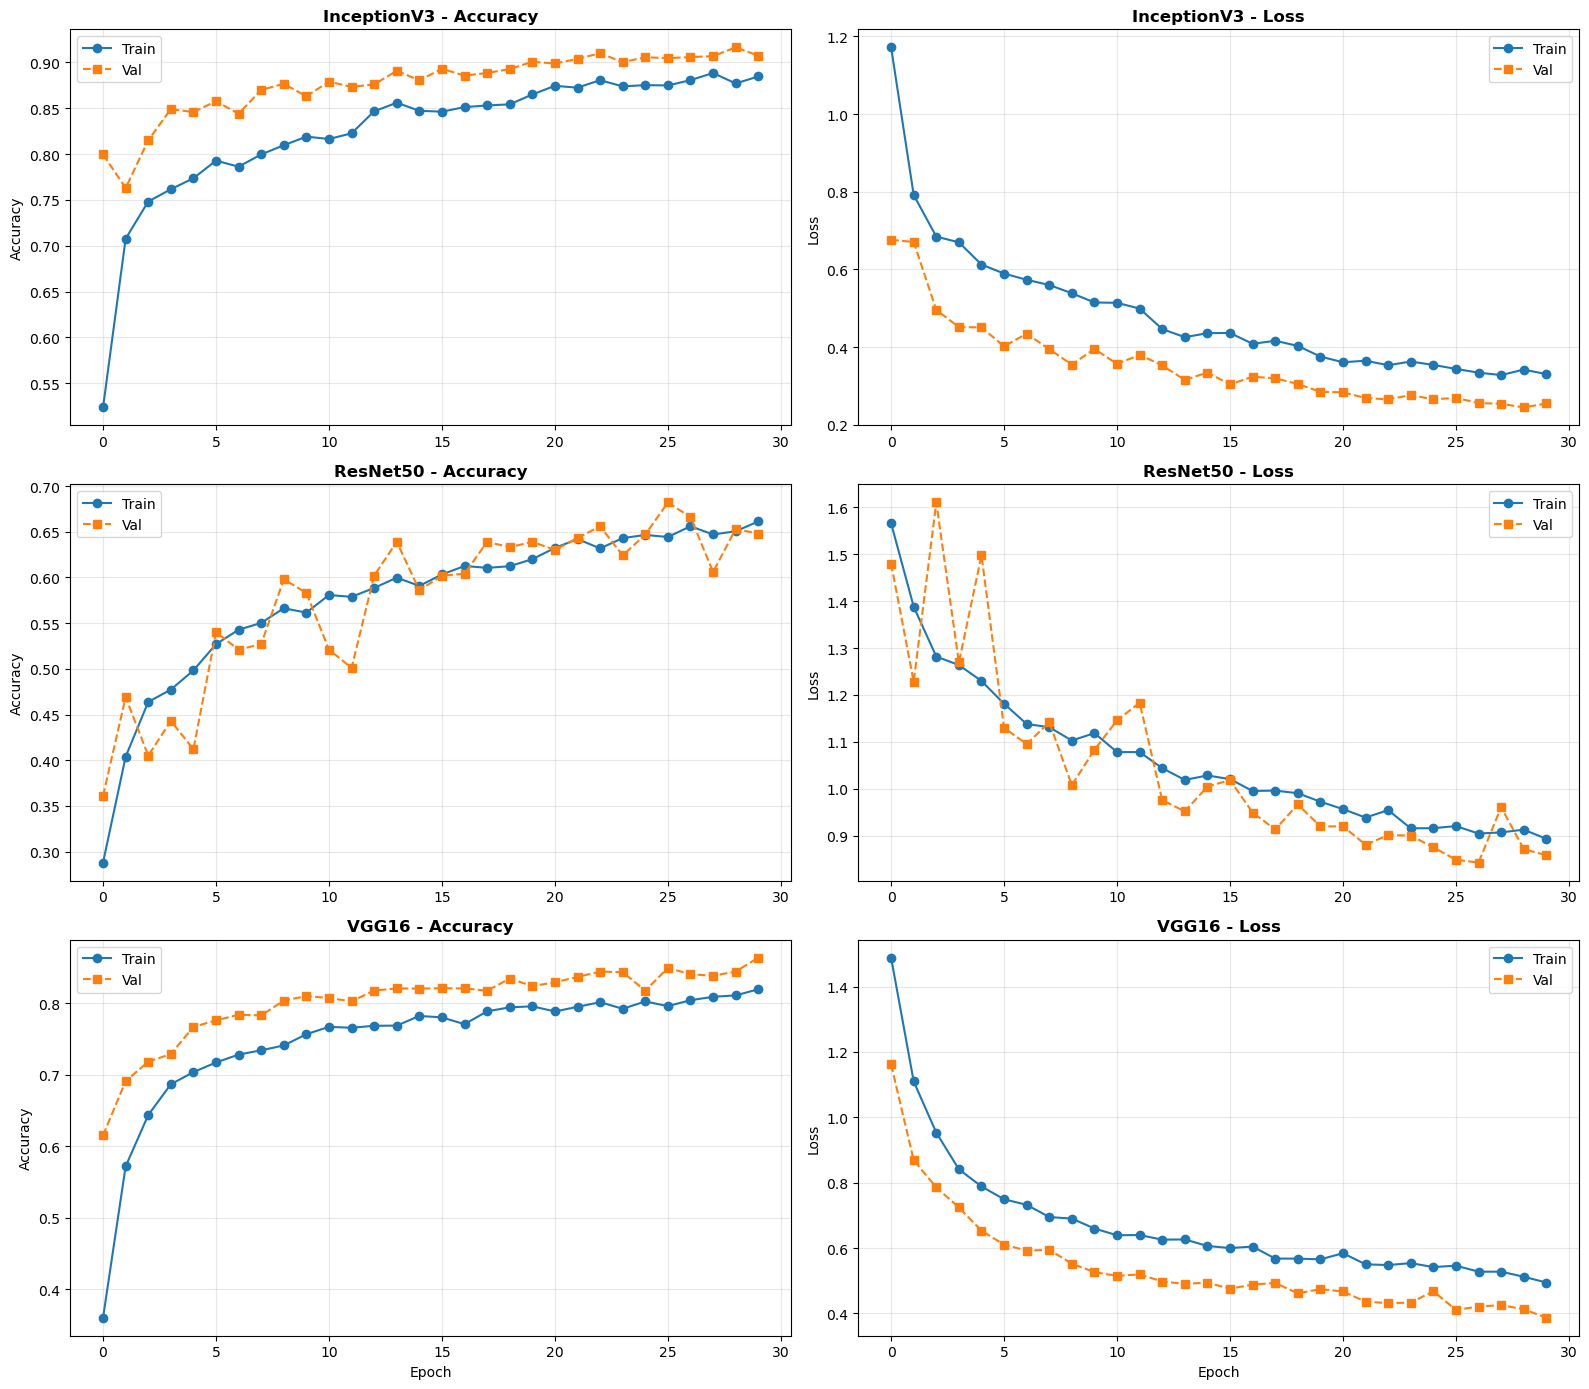

In [18]:
# ============================================================================
# PART 8 : LEARNING CURVES VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 8 : LEARNING CURVES VISUALIZATION")
print("=" * 80)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Model 1: InceptionV3
axes[0, 0].plot(history_1.history['accuracy'], label='Train', marker='o')
axes[0, 0].plot(history_1.history['val_accuracy'], label='Val', marker='s', linestyle='--')
axes[0, 0].set_title('InceptionV3 - Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_1.history['loss'], label='Train', marker='o')
axes[0, 1].plot(history_1.history['val_loss'], label='Val', marker='s', linestyle='--')
axes[0, 1].set_title('InceptionV3 - Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Model 2: ResNet50
axes[1, 0].plot(history_2.history['accuracy'], label='Train', marker='o')
axes[1, 0].plot(history_2.history['val_accuracy'], label='Val', marker='s', linestyle='--')
axes[1, 0].set_title('ResNet50 - Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_2.history['loss'], label='Train', marker='o')
axes[1, 1].plot(history_2.history['val_loss'], label='Val', marker='s', linestyle='--')
axes[1, 1].set_title('ResNet50 - Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Model 3: VGG16
axes[2, 0].plot(history_3.history['accuracy'], label='Train', marker='o')
axes[2, 0].plot(history_3.history['val_accuracy'], label='Val', marker='s', linestyle='--')
axes[2, 0].set_title('VGG16 - Accuracy', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(history_3.history['loss'], label='Train', marker='o')
axes[2, 1].plot(history_3.history['val_loss'], label='Val', marker='s', linestyle='--')
axes[2, 1].set_title('VGG16 - Loss', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=100, bbox_inches='tight')
plt.show()


STEP 9 : MODELS COMPARISON

      Model  Learning Rate Input Size  Test Accuracy  Test Loss
InceptionV3         0.0010    299x299        0.91120   0.250685
   ResNet50         0.0005    224x224        0.67000   0.849962
      VGG16         0.0010    224x224        0.86325   0.384668


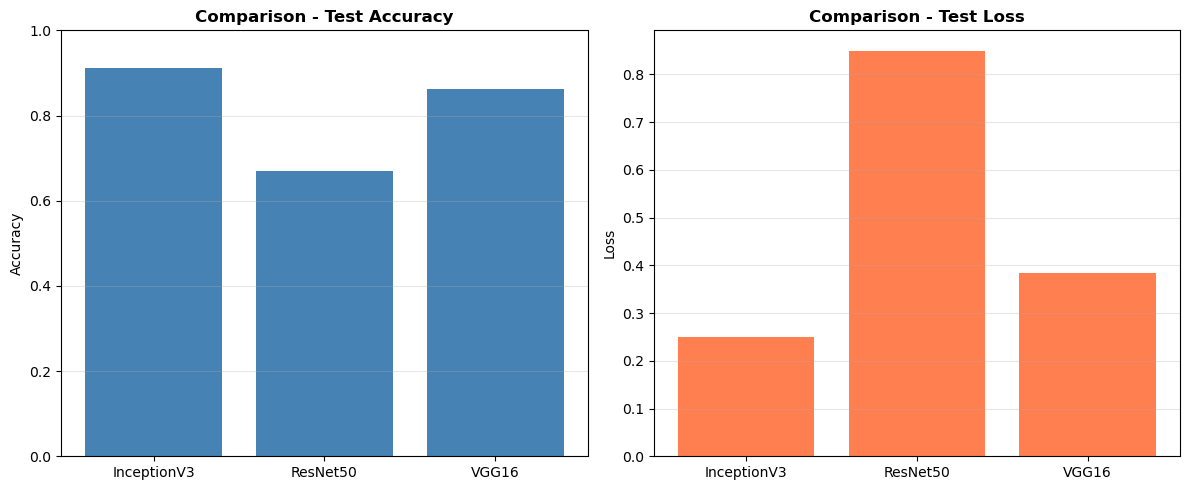

In [28]:
# ============================================================================
# PART 9 : MODELS COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("STEP 9 : MODELS COMPARISON")
print("=" * 80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['InceptionV3', 'ResNet50', 'VGG16'],
    'Learning Rate': [learning_rate_1, learning_rate_2, learning_rate_1],
    'Input Size': ['299x299', '224x224', '224x224'],
    'Test Accuracy': [test_acc_1, test_acc_2, test_acc_3],
    'Test Loss': [test_loss_1, test_loss_2, test_loss_3]
})

print("\n" + comparison_df.to_string(index=False))

# ============================
# Visualization
# ============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test Accuracy
axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color='steelblue')
axes[0].set_title('Comparison - Test Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Test Loss
axes[1].bar(comparison_df['Model'], comparison_df['Test Loss'], color='coral')
axes[1].set_title('Comparison - Test Loss', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/content/models_comparison.png', dpi=100, bbox_inches='tight')
plt.show()


In [29]:
# ============================================================================
# PART 10 : BEST MODEL AND DETAILED METRICS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 10 : BEST MODEL")
print("=" * 80)

best_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Test Accuracy']

print(f"\n Best model: {best_model_name}")
print(f" Accuracy: {best_accuracy:.4f}")
print(f" Loss: {comparison_df.loc[best_idx, 'Test Loss']:.4f}")



STEP 10 : BEST MODEL

 Best model: InceptionV3
 Accuracy: 0.9112
 Loss: 0.2507


In [30]:
# ============================================================================
# PART 11 : SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 11 : SAVE RESULTS")
print("=" * 80)

comparison_df.to_csv('/content/models_comparison.csv', index=False)
print(" Comparison table saved: /content/models_comparison.csv")

print(" InceptionV3 saved: /content/inceptionv3_001.h5")
print(" ResNet50 saved: /content/resnet50_0005.h5")
print(" VGG16 saved: /content/vgg16_001.h5")

print("\n" + "=" * 80)
print("TRANSFER LEARNING PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 80)


STEP 11 : SAVE RESULTS
 Comparison table saved: /content/models_comparison.csv
 InceptionV3 saved: /content/inceptionv3_001.h5
 ResNet50 saved: /content/resnet50_0005.h5
 VGG16 saved: /content/vgg16_001.h5

TRANSFER LEARNING PROJECT COMPLETED SUCCESSFULLY!


In [31]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\nFINAL SUMMARY:")
print(f"  - Dataset: {len(image_paths)} images, {num_classes} classes")
print(f"  - Models trained: 3 (InceptionV3, ResNet50, VGG16)")
print(f"  - Best model: {best_model_name} ({best_accuracy:.4f})")
print(f"  - Data augmentation: Rotation, Zoom, Flip, Brightness")
print(f"  - Callbacks used: EarlyStopping, ReduceLROnPlateau")


FINAL SUMMARY:
  - Dataset: 5000 images, 5 classes
  - Models trained: 3 (InceptionV3, ResNet50, VGG16)
  - Best model: InceptionV3 (0.9112)
  - Data augmentation: Rotation, Zoom, Flip, Brightness
  - Callbacks used: EarlyStopping, ReduceLROnPlateau
